## Particle within radius or overlap calculations

In [3]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [71]:
# set_number = 5
dir_save = '../../data/Sprints/AN/'
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/Run03/Set05/'
run = 'wind05Run03_InterpolatedX.hdf'

df = pd.read_hdf(dir+run)
# x=pd.read_hdf(dir+'Coll03_WindPath.h5')

In [41]:
# df =pd.DataFrame()
# df=dat[149942:]
# df.reset_index(inplace=True, drop=True)

### Calculate Expected encounters

In [72]:
sync_time = df.master_time-df.master_time[0]
dt=df.master_time[1]-df.master_time[0]
df.insert(1,'sync_time',sync_time)
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
# source = np.array([[0,0]])
# distance_from_source = np.array([cdist(odor_position,source)]).flatten()

### Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2




In [73]:
#summation till Nth particle
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

# container=pd.DataFrame()
# container['eastwest']=eastwest
# container['northsouth']=northsouth

# container.to_hdf(dir+'Coll03_WindPath.h5', key='df', mode='w')

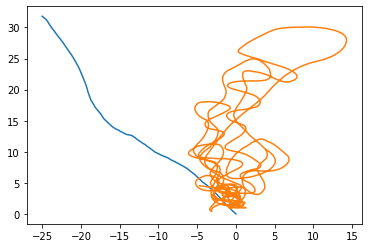

In [75]:
plt.plot(eastwest[-4000:], northsouth[-4000:])
plt.plot(df.xsrc, df.ysrc)

In [76]:
#initialize list containers

odor_presence=[]
points_along_streakline = []
nearest_particle= []

window = 4000

# eastwest = x.eastwest
# northsouth = x.northsouth

In [48]:
len(eastwest)-60000

89943

In [77]:
#for(upper, lower, step)
for i in range((len(eastwest))-1,window, -1):
    
    odor_pos = [odor_position[i]]  
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-window:],northsouth[-window:]]).T   
    radius = np.arange(start = window, stop = 0, step = -1)**0.5*0.01
    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    nearest_particle.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))

    points_along_streakline.append(wind_pos[int(pos[0]):])
    
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [51]:
for i in range((len(eastwest))-1,window, -1):
    
    odor_pos = [odor_position[i]]  
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-window:],northsouth[-window:]]).T   
    radius = np.arange(start = window, stop = 0, step = -1)**0.5*0.01
    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    nearest_particle.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))

    points_along_streakline.append(wind_pos[int(pos[0]):])
    
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [78]:
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        radius = np.arange(start = i, stop = 0, step = -1)**0.5*0.01
    
    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    nearest_particle.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))
    points_along_streakline.append(wind_pos[int(pos[0]):])
        
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [82]:
len(points_along_streakline)

59770

In [80]:
distance_along_streakline=[]
# for i in range(0,50000):
#     lengths = np.sqrt(np.sum(np.diff(np.array(points_along_streakline[i]), axis=0)**2, axis=1)) # Length between corners
#     distance_along_streakline.append(np.sum(lengths))

In [55]:
for i in range(50000,100000):
    lengths = np.sqrt(np.sum(np.diff(np.array(points_along_streakline[i]), axis=0)**2, axis=1)) # Length between corners
    distance_along_streakline.append(np.sum(lengths))

In [81]:
for i in range(0,len(points_along_streakline)):
    lengths = np.sqrt(np.sum(np.diff(np.array(points_along_streakline[i]), axis=0)**2, axis=1)) # Length between corners
    distance_along_streakline.append(np.sum(lengths))

In [83]:
len(distance_along_streakline) 

59770

In [84]:
## flip containers because above iteration is done in reverse order
df['mock'] = np.zeros(len(df))
distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
odor_presence = odor_presence[::-1]
# max_radius = max_radius[::-1]

## storing in the dataframe 
df['odor_expected'] = odor_presence
df['distance_along_streakline'] =  distance_along_streakline
df['nearest_particle'] = nearest_particle
# df['distance_from_source'] = distance_from_source

In [85]:
df.to_hdf(dir+'Run03Set05_expected_full.h5', key='df', mode='w')


In [61]:
df1 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Collections/Coll02_01_expected.h5') 
df2 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Collections/Coll02_02_expected.h5') 
df = pd.concat([df1,df2])
df.reset_index(inplace=True, drop=True)

In [63]:
df.to_hdf(dir+'Coll02_expected.h5', key='df', mode='w')

